#**Thai sentiment analysis about education in Thailand on Twitter.** 🙂😐☹️

# **Model & Validation process** ⚙️🔨

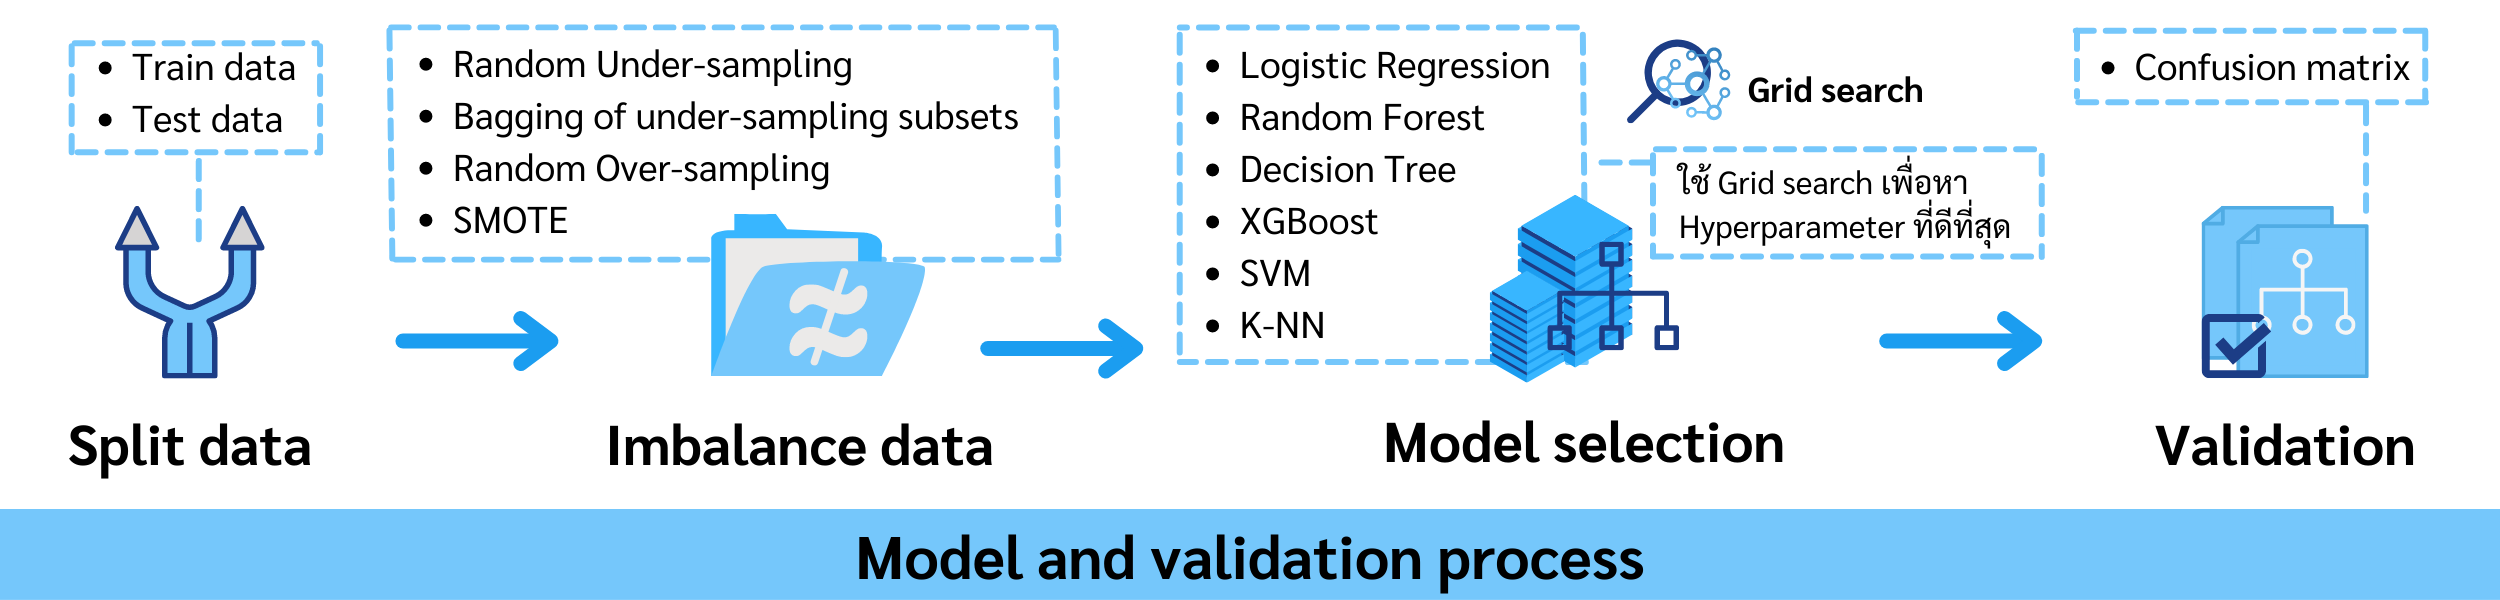


### การนำเข้าแพ็คเกจที่จำเป็น

In [ ]:
!pip install pythainlp
!pip install stop-words
!pip install stopwords
!pip install python-crfsuite

import pandas as pd
import tweepy as tw
import numpy as np 

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words

# from nltk.tokenize import word_tokenize
import pythainlp
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

from sklearn.model_selection import train_test_split

import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import pickle as p
import plotly
import plotly.graph_objs as go

import urllib
import requests

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

## Load pickle files

In [ ]:
import pickle
# load the TFIDF from disk
TFIDF = pickle.load(open('TFIDF.pkl', 'rb'))

# load the label from disk
label = pickle.load(open('label.pkl', 'rb'))

# Split data

In [ ]:
from sklearn.model_selection import train_test_split # ทำการแบ่งข้อมูลฝึกสอนและทดสอบ

X_bg = TFIDF 
y_bg = label

# ข้อมูลฝึกสอนและทดสอบ
X_train_bg, X_test, y_train_bg, y_test = train_test_split(X_bg, y_bg, test_size = 0.3, random_state = 42)

In [ ]:
# ขนาดข้อมูลฝึกสอนและทดสอบ
X_train_bg.shape, y_train_bg.shape, X_test.shape, y_test.shape

((4267, 1000), (4267,), (1830, 1000), (1830,))

In [ ]:
# Class distribution
df_bg = pd.DataFrame(y_train_bg)
df_bg.value_counts()

category
-1          2322
0           1716
1            229
dtype: int64

# Model and validation


##Grid search    
[CS51_Grid search.ipynb]

In [1]:
from sklearn.metrics import f1_score

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier

Log_Reg = LogisticRegression(random_state=0,C= 2, max_iter=100, penalty= 'l2',solver= 'liblinear')
Log_Reg = BaggingClassifier(Log_Reg, #โมเดลที่ใช้
                        n_estimators=100, #The number of base estimators in the ensemble.
                        max_samples=0.8, #จำนวนตัวอย่างที่จะใช้แต่ละตัว The number of samples to draw from X to train each base estimator.
                        random_state=42) 

Log_Reg.fit(X_train_bg, y_train_bg)

BaggingClassifier(base_estimator=LogisticRegression(C=2, random_state=0,
                                                    solver='liblinear'),
                  max_samples=0.8, n_estimators=100, random_state=42)

In [ ]:
prediction_tfidf = Log_Reg.predict_proba(X_test)
prediction_tfidf  = np.argmax(prediction_tfidf ,axis=1)
prediction_int = prediction_tfidf -1

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_test.apply(pd.to_numeric), prediction_int, average='weighted')

log_tfidf

0.6688116338387267

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), prediction_int))

              precision    recall  f1-score   support

          -1       0.73      0.80      0.76      1023
           0       0.62      0.60      0.61       722
           1       1.00      0.02      0.05        85

    accuracy                           0.69      1830
   macro avg       0.78      0.48      0.47      1830
weighted avg       0.70      0.69      0.67      1830



Text(23.999999999999996, 0.5, 'Actual')

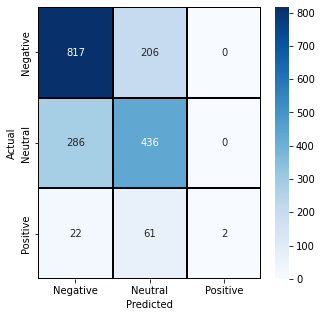

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), prediction_int)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

##XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:

from sklearn.ensemble import BaggingClassifier

model_tfidf = XGBClassifier(random_state=29,learning_rate=0.7,colsample_bytree=1.0, gamma=2, max_depth=5,
              objective='multi:softprob', subsample=0.6)
Log_Reg = BaggingClassifier(model_tfidf , #โมเดลที่ใช้
                        n_estimators=100, #The number of base estimators in the ensemble.
                        max_samples=0.8, #จำนวนตัวอย่างที่จะใช้แต่ละตัว The number of samples to draw from X to train each base estimator.
                        random_state=42) 

Log_Reg.fit(X_train_bg, y_train_bg)

BaggingClassifier(base_estimator=XGBClassifier(colsample_bytree=1.0, gamma=2,
                                               learning_rate=0.7, max_depth=5,
                                               objective='multi:softprob',
                                               random_state=29, subsample=0.6),
                  max_samples=0.8, n_estimators=100, random_state=42)

In [ ]:
xgb_tfidf= Log_Reg.predict_proba(X_test)
xgb_tfidf = np.argmax(xgb_tfidf,axis=1)
xgb_tfidf = xgb_tfidf-1
xgb_tfidf 

array([ 0,  0,  0, ..., -1, -1,  0])

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#xgb_tfidf=xgb_tfidf[:,1]>=0.3

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf.astype(np.int)

# calculating f1 score
score=f1_score(y_test.apply(pd.to_numeric),xgb_int_tfidf, average='weighted')

score

0.6433977163058613

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), xgb_int_tfidf))

              precision    recall  f1-score   support

          -1       0.71      0.77      0.74      1023
           0       0.59      0.58      0.58       722
           1       0.17      0.01      0.02        85

    accuracy                           0.66      1830
   macro avg       0.49      0.45      0.45      1830
weighted avg       0.64      0.66      0.64      1830



Text(23.999999999999996, 0.5, 'Actual')

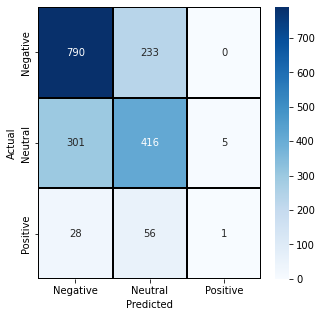

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), xgb_int_tfidf)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import BaggingClassifier

dct = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=20, random_state=42)
Log_Reg = BaggingClassifier(dct , #โมเดลที่ใช้
                        n_estimators=100, #The number of base estimators in the ensemble.
                        max_samples=0.8, #จำนวนตัวอย่างที่จะใช้แต่ละตัว The number of samples to draw from X to train each base estimator.
                        random_state=42) 

Log_Reg.fit(X_train_bg, y_train_bg)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=20,
                                                        min_samples_leaf=20,
                                                        random_state=42),
                  max_samples=0.8, n_estimators=100, random_state=42)

In [ ]:
dct_tfidf = Log_Reg.predict_proba(X_test)
dct_tfidf = np.argmax(dct_tfidf ,axis=1)
dct_tfidf = dct_tfidf -1
dct_tfidf

array([ 0,  0, -1, ..., -1, -1,  0])

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_test.apply(pd.to_numeric),dct_int_tfidf, average='weighted')

dct_score_tfidf

0.633611563447629

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), dct_int_tfidf))

              precision    recall  f1-score   support

          -1       0.72      0.71      0.72      1023
           0       0.56      0.63      0.59       722
           1       0.00      0.00      0.00        85

    accuracy                           0.65      1830
   macro avg       0.43      0.45      0.44      1830
weighted avg       0.62      0.65      0.63      1830



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(23.999999999999996, 0.5, 'Actual')

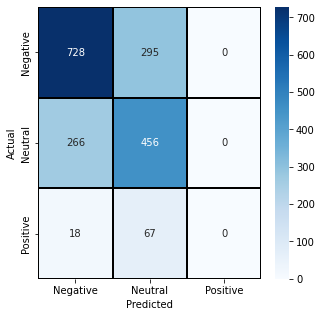

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), dct_int_tfidf)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=6, max_leaf_nodes=5, max_samples=0.8,
                       min_samples_leaf=3,min_samples_split= 2)
Log_Reg = BaggingClassifier(text_classifier, #โมเดลที่ใช้
                        n_estimators=100, #The number of base estimators in the ensemble.
                        max_samples=0.8, #จำนวนตัวอย่างที่จะใช้แต่ละตัว The number of samples to draw from X to train each base estimator.
                        random_state=42) 

Log_Reg.fit(X_train_bg, y_train_bg)

BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=6,
                                                        max_leaf_nodes=5,
                                                        max_samples=0.8,
                                                        min_samples_leaf=3,
                                                        n_estimators=200,
                                                        random_state=0),
                  max_samples=0.8, n_estimators=100, random_state=42)

In [ ]:
predictions = Log_Reg.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print('Accuracy :',accuracy_score(y_test, predictions))

[[1023    0    0]
 [ 722    0    0]
 [  85    0    0]]
              precision    recall  f1-score   support

          -1       0.56      1.00      0.72      1023
           0       0.00      0.00      0.00       722
           1       0.00      0.00      0.00        85

    accuracy                           0.56      1830
   macro avg       0.19      0.33      0.24      1830
weighted avg       0.31      0.56      0.40      1830

Accuracy : 0.559016393442623


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(23.999999999999996, 0.5, 'Actual')

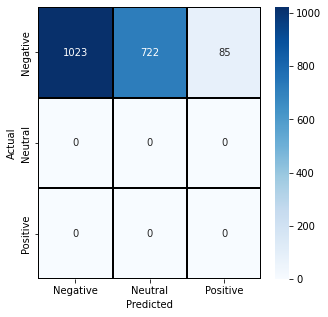

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##K-Nearest Neighbour


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_bg)

X_train = scaler.transform(X_train_bg)
X_test = scaler.transform(X_test)



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
classifier = KNeighborsClassifier(n_neighbors=5,n_jobs=-1, weights='distance',algorithm= 'auto', leaf_size= 30, metric= 'minkowski',p= 2)

Log_Reg = BaggingClassifier(classifier, #โมเดลที่ใช้
                        n_estimators=100, #The number of base estimators in the ensemble.
                        max_samples=0.8, #จำนวนตัวอย่างที่จะใช้แต่ละตัว The number of samples to draw from X to train each base estimator.
                        random_state=42) 

Log_Reg.fit(X_train_bg, y_train_bg)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=-1,
                                                      weights='distance'),
                  max_samples=0.8, n_estimators=100, random_state=42)

ขั้นตอนแรกคือการนำเข้าKNeighborsClassifierคลาสจากsklearn.neighborsไลบรารี n_neigboursในบรรทัดที่สองชั้นนี้จะเริ่มต้นได้ด้วยพารามิเตอร์หนึ่งคือ นี่คือค่าของ K โดยพื้นฐานแล้ว ไม่มีค่าในอุดมคติสำหรับ K และค่านี้จะถูกเลือกหลังจากการทดสอบและประเมินผล อย่างไรก็ตาม ในการเริ่มต้น ดูเหมือนว่า 5 จะเป็นค่าที่ใช้บ่อยที่สุดสำหรับอัลกอริทึม KNN

In [ ]:
y_pred = Log_Reg.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[644 374   5]
 [312 401   9]
 [ 36  44   5]]
              precision    recall  f1-score   support

          -1       0.65      0.63      0.64      1023
           0       0.49      0.56      0.52       722
           1       0.26      0.06      0.10        85

    accuracy                           0.57      1830
   macro avg       0.47      0.41      0.42      1830
weighted avg       0.57      0.57      0.57      1830



Text(23.999999999999996, 0.5, 'Actual')

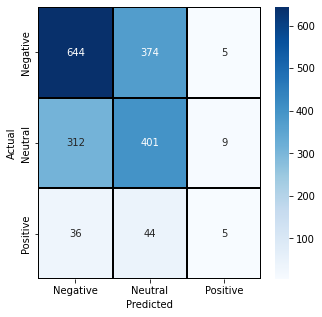

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##SVM

###Vectorizing the data

Creating a Linear SVM Model

In [ ]:
import time
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
#classifier_linear = svm.SVC(kernel='linear')


In [ ]:
# train the model on train set
#hyperparameter
#C=1, kernel='rbf', gamma=0.01

from sklearn.ensemble import BaggingClassifier
model = SVC(C=100, gamma=0.001,kernel= 'rbf')
Log_Reg = BaggingClassifier(model, #โมเดลที่ใช้
                        n_estimators=100, #The number of base estimators in the ensemble.
                        max_samples=0.8, #จำนวนตัวอย่างที่จะใช้แต่ละตัว The number of samples to draw from X to train each base estimator.
                        random_state=42) 

Log_Reg.fit(X_train_bg, y_train_bg)
 
# print prediction results
predictions = Log_Reg.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.61      0.95      0.74      1023
           0       0.66      0.12      0.20       722
           1       0.26      0.32      0.29        85

    accuracy                           0.59      1830
   macro avg       0.51      0.46      0.41      1830
weighted avg       0.61      0.59      0.51      1830



Text(23.999999999999996, 0.5, 'Actual')

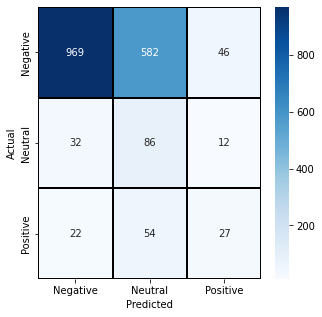

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
from sklearn.ensemble import BaggingClassifier
MNB = MultinomialNB(alpha=100, fit_prior=True, class_prior=None)
Log_Reg = BaggingClassifier(MNB, #โมเดลที่ใช้
                        n_estimators=100, #The number of base estimators in the ensemble.
                        max_samples=0.8, #จำนวนตัวอย่างที่จะใช้แต่ละตัว The number of samples to draw from X to train each base estimator.
                        random_state=42) 

Log_Reg.fit(X_train_bg, y_train_bg)


BaggingClassifier(base_estimator=MultinomialNB(alpha=100), max_samples=0.8,
                  n_estimators=100, random_state=42)

In [ ]:
predictions = Log_Reg.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.60      0.94      0.74      1023
           0       0.61      0.20      0.30       722
           1       0.00      0.00      0.00        85

    accuracy                           0.60      1830
   macro avg       0.40      0.38      0.34      1830
weighted avg       0.58      0.60      0.53      1830



Text(23.999999999999996, 0.5, 'Actual')

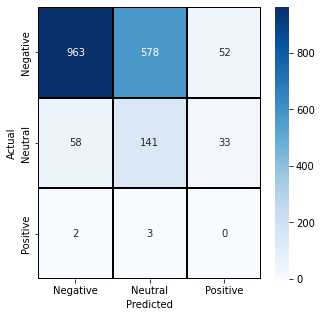

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
